<a href="https://colab.research.google.com/github/Neurosecond/Notebooks/blob/main/MLSemSeg_DeepLabV3%2B(encoder).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### В этом ноутбуке используется модель сегментации изображений [DeepLabV3+](https://arxiv.org/abs/1802.02611) .

In [1]:
import os, cv2, math
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.utils.model_zoo as model_zoo
import albumentations as album

In [2]:
!pip install torchmetrics tensorboardX
import torchmetrics
import tensorboardX
from torchmetrics import JaccardIndex
from tensorboardX import SummaryWriter

In [5]:
import torch
print(torch.cuda.is_available())

False


In [3]:
!pip install wandb
import wandb

In [4]:
wandb.login()

wandb: Currently logged in as: buchkevich. Use `wandb login --relogin` to force relogin


True

### Определение train / val / test директорий 📁

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
# DATA_DIR = 'https://drive.google.com/drive/folders/1HX8vcLuRvSlEBzkLpPPA55EkF84mUZX6?usp=sharing'
# DATA_DIR = 'D:/MassachusettsBuildingsDataset/tiff'
DATA_DIR = '/content/drive/My Drive/MassachusettsBuildingsDataset/tiff/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')
# x_train_dir = ('/content/drive/My Drive/MassachusettsBuildingsDataset/tiff/train')
# y_train_dir = ('/content/drive/My Drive/MassachusettsBuildingsDataset/tiff/train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')
# x_valid_dir = ('/content/drive/My Drive/MassachusettsBuildingsDataset/tiff/val')
# y_valid_dir = ('/content/drive/My Drive/MassachusettsBuildingsDataset/tiff/val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')
# x_test_dir = ('/content/drive/My Drive/MassachusettsBuildingsDataset/tiff/test')
# y_test_dir = ('/content/drive/My Drive/MassachusettsBuildingsDataset/tiff/test_labels')

In [7]:
%cd /content/drive/My Drive/MassachusettsBuildingsDataset/

class_dict = pd.read_csv("label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

/content/drive/My Drive/MassachusettsBuildingsDataset
All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


#### Список конкретных классов для сегментации

In [8]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'building']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


### Вспомогательные функции для viz. & one-hot encoding/decoding

In [9]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [10]:
class BuildingsDataset(torch.utils.data.Dataset):

    """Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        # self.class_rgb_values = class_rgb_values
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

#### Визуализируем образец изображения и маску

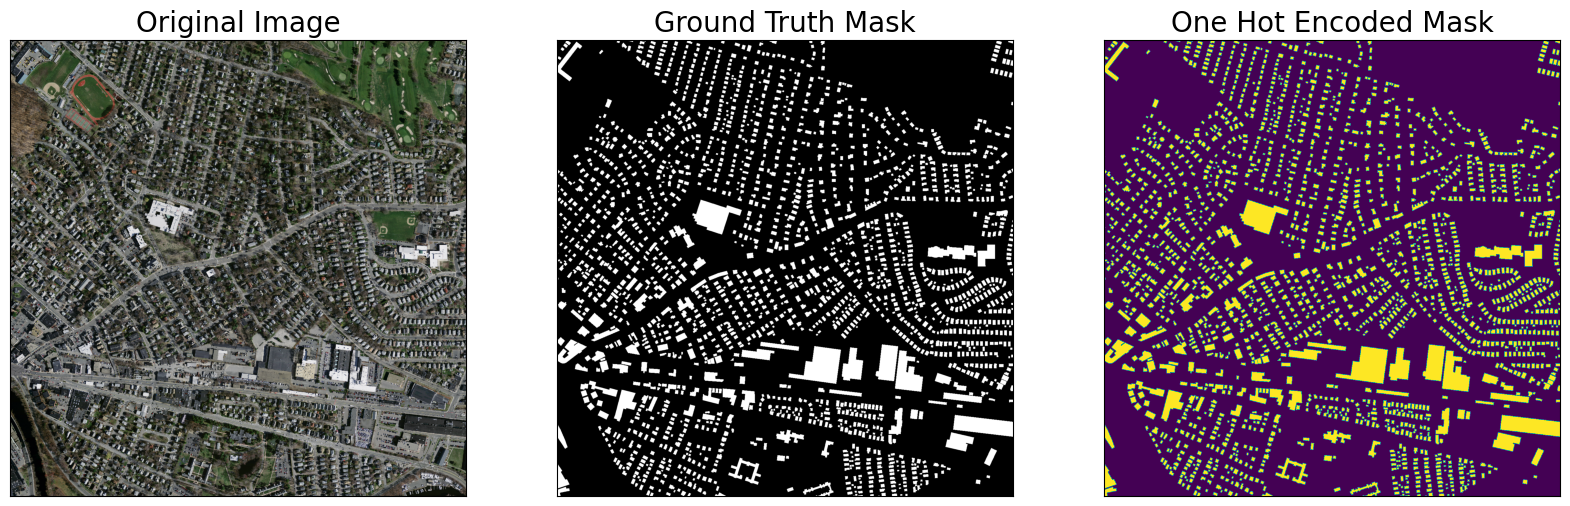

In [11]:
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Определяем аугументации

In [12]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

#### Визуализируем аугументированные изображения и маски

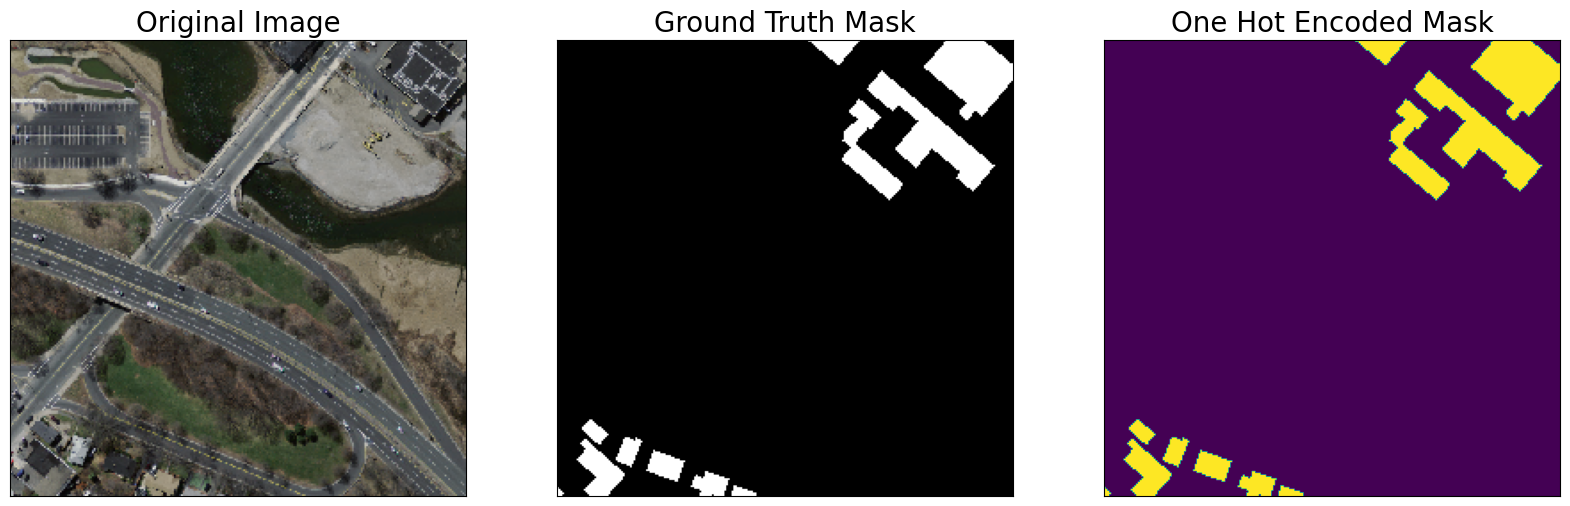

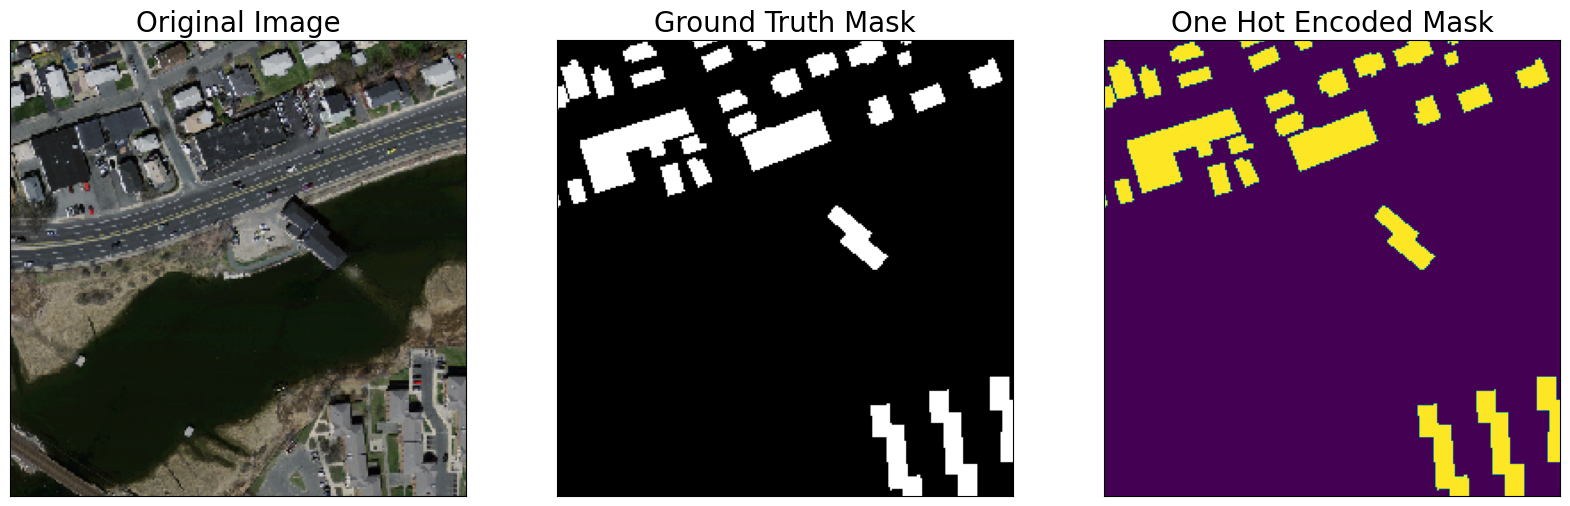

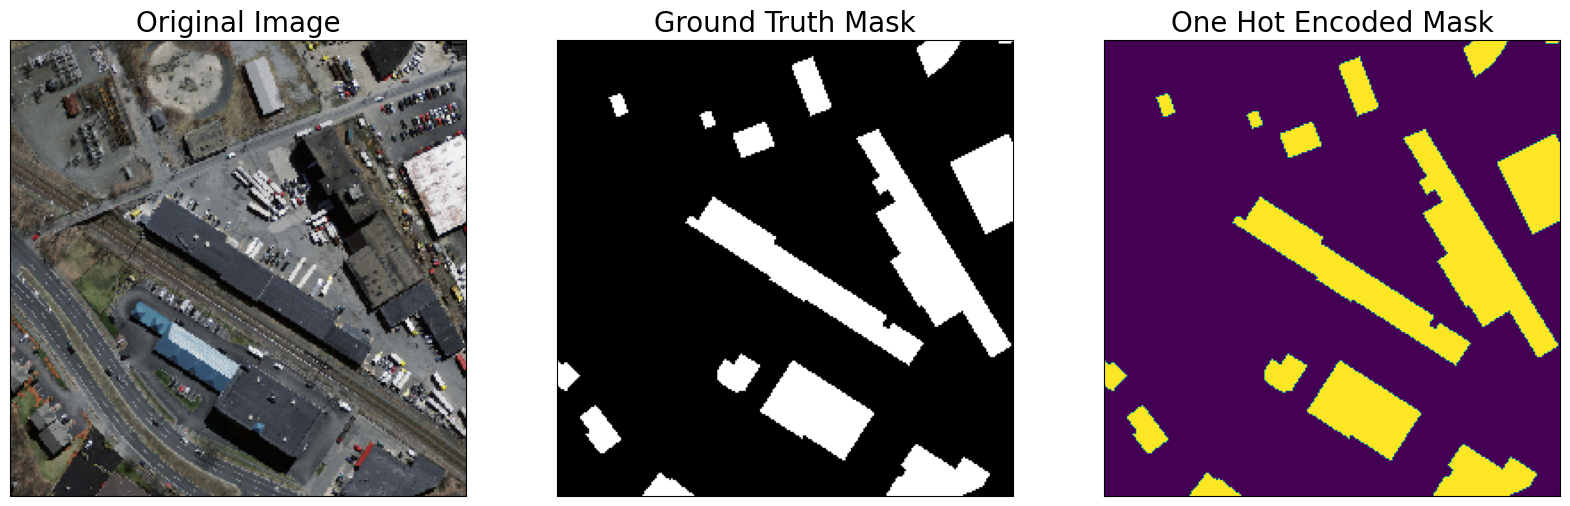

In [13]:
augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## Тренеровка DeepLabV3+ с произвольным ResNet-like энкодером

### Определение модели

In [14]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, rate=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               dilation=rate, padding=rate, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.rate = rate

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [15]:
class ResNet(nn.Module):

    def __init__(self, nInputChannels, block, layers, os=16, pretrained=False):
        self.inplanes = 64
        super(ResNet, self).__init__()
        if os == 16:
            strides = [1, 2, 2, 1]
            rates = [1, 1, 1, 2]
            blocks = [1, 2, 4]
        elif os == 8:
            strides = [1, 2, 1, 1]
            rates = [1, 1, 2, 2]
            blocks = [1, 2, 1]
        else:
            raise NotImplementedError

        # Modules
        self.conv1 = nn.Conv2d(nInputChannels, 64, kernel_size=7, stride=2, padding=3,
                                bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=strides[0], rate=rates[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=strides[1], rate=rates[1])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=strides[2], rate=rates[2])
        self.layer4 = self._make_MG_unit(block, 512, blocks=blocks, stride=strides[3], rate=rates[3])

        self._init_weight()

        if pretrained:
            self._load_pretrained_model()

    def _make_layer(self, block, planes, blocks, stride=1, rate=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, rate, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _make_MG_unit(self, block, planes, blocks=[1,2,4], stride=1, rate=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, rate=blocks[0]*rate, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, len(blocks)):
            layers.append(block(self.inplanes, planes, stride=1, rate=blocks[i]*rate))

        return nn.Sequential(*layers)

    def forward(self, input):

        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        low_level_feat = x
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x, low_level_feat

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _load_pretrained_model(self):
        pretrain_dict = model_zoo.load_url('https://download.pytorch.org/models/resnet101-5d3b4d8f.pth')
        model_dict = {}
        state_dict = self.state_dict()
        for k, v in pretrain_dict.items():
            if k in state_dict:
                model_dict[k] = v
        state_dict.update(model_dict)
        self.load_state_dict(state_dict)

In [16]:
def ResNetUni(nInputChannels=3, os=16, pretrained=False):
    model = ResNet(nInputChannels, Bottleneck, [3, 4, 23, 3], os, pretrained=pretrained)
    # model = ResNet(nInputChannels, Bottleneck, [2, 2, 2, 2], os, pretrained=pretrained)
    return model

In [17]:
class ASPP_module(nn.Module):
    def __init__(self, inplanes, planes, rate):
        super(ASPP_module, self).__init__()
        if rate == 1:
            kernel_size = 1
            padding = 0
        else:
            kernel_size = 3
            padding = rate
        self.atrous_convolution = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                                            stride=1, padding=padding, dilation=rate, bias=False)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_convolution(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [18]:
class DeepLabv3_plus(nn.Module):
    def __init__(self, nInputChannels=3, n_classes=21, os=16, pretrained=False, _print=True):
        if _print:
            print("Constructing DeepLabv3+ model...")
            print("Number of classes: {}".format(n_classes))
            print("Output stride: {}".format(os))
            print("Number of Input Channels: {}".format(nInputChannels))
        super(DeepLabv3_plus, self).__init__()

        # Atrous Conv
        self.resnet_features = ResNetUni(nInputChannels, os, pretrained=pretrained)

        # ASPP
        if os == 16:
            rates = [1, 6, 12, 18]
        elif os == 8:
            rates = [1, 12, 24, 36]
        else:
            raise NotImplementedError

        self.aspp1 = ASPP_module(2048, 256, rate=rates[0])
        self.aspp2 = ASPP_module(2048, 256, rate=rates[1])
        self.aspp3 = ASPP_module(2048, 256, rate=rates[2])
        self.aspp4 = ASPP_module(2048, 256, rate=rates[3])

        self.relu = nn.ReLU()

        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(2048, 256, 1, stride=1, bias=False),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU())

        self.conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(256)

        # adopt [1x1, 48] for channel reduction.
        self.conv2 = nn.Conv2d(256, 48, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(48)

        self.last_conv = nn.Sequential(nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(256, n_classes, kernel_size=1, stride=1))

    def forward(self, input):
        x, low_level_features = self.resnet_features(input)
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        low_level_features = self.conv2(low_level_features)
        low_level_features = self.bn2(low_level_features)
        low_level_features = self.relu(low_level_features)

        x = F.interpolate(x, size=low_level_features.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x, low_level_features), dim=1)
        x = self.last_conv(x)
        x = F.interpolate(x, size=input.size()[2:], mode='bilinear', align_corners=True)
        return x

    def freeze_bn(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [19]:
def cross_entropy2d(logit, target, ignore_index=255, weight=None, size_average=True, batch_average=True):
    n, c, h, w = logit.size()
    target = torch.argmax(target, dim=1)

    if weight is None:
        criterion = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index, size_average=False)
    else:
        criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(np.array(weight)).float().cuda(),
                                        ignore_index=ignore_index, size_average=False)
    loss = criterion(logit.float(), target.long())

    if size_average:
        loss /= (h * w)

    if batch_average:
        loss /= n

    return loss

In [23]:
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
writer = SummaryWriter()
model = DeepLabv3_plus(nInputChannels=3, n_classes=len(select_classes), os=16, pretrained=False, _print=True)

Constructing DeepLabv3+ model...
Number of classes: 2
Output stride: 16
Number of Input Channels: 3


#### Запрашиваем Train / Val DataLoader'ы

In [24]:
# Get train and val dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(),
    class_rgb_values=select_class_rgb_values
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(),
    class_rgb_values=select_class_rgb_values
)

# Get train and val data loaders
train_batch = 16
valid_batch = 1
train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, num_workers=5)
valid_loader = DataLoader(valid_dataset, batch_size=valid_batch, shuffle=False, num_workers=2)

#### Настраиваем гиперпараметры модели

In [25]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 30

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss_fn = cross_entropy2d

# define optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

jaccard = JaccardIndex(num_classes=len(select_classes), task='binary')

# model.to(DEVICE)

#### Определяем функцию вычисления метрик

In [ ]:
def compute_metrics(outputs, labels):
    # Преобразование выходных данных модели и меток в бинарные маски
    predicted_masks = (outputs > 0.5).float()
    true_masks = (labels > 0.5).float()

    # compute metrics
    intersection = (predicted_masks * true_masks).sum()
    union = (predicted_masks + true_masks).sum() - intersection
    iou = intersection / union

    dice_numerator = 2 * intersection
    dice_denominator = predicted_masks.sum() + true_masks.sum()
    dice = dice_numerator / dice_denominator

    return iou.item(), dice.item()

### Проводим процесс машинного обучения DeepLabV3+

In [26]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-third-project",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "DeepLabV3+(encoder)",
    "dataset": "MassachusettsBuildings",
    "epochs": 30,
    }
)

In [27]:
import timeit

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    running_loss_tr = 0.0
    running_loss_val = 0.0
    train_logs_iou_list, train_logs_dice_list = [], []
    valid_logs_iou_list, valid_logs_dice_list = [], []
    num_img_tr = len(train_loader)
    num_img_val = len(valid_loader)

    for epoch in range(0, EPOCHS):
        # Perform training & validation
        print('\nEpoch: {}'.format(epoch))
        start_time = timeit.default_timer()
        model.train()
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.float(), targets.float()
            inputs, targets = Variable(inputs, requires_grad=True), Variable(targets)

            # inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = model.forward(inputs)
            loss = loss_fn(outputs, targets, size_average=False, batch_average=True)
            running_loss_tr += loss.item()

            # Print stuff
            if i % num_img_tr == (num_img_tr - 1):
                running_loss_tr = running_loss_tr / num_img_tr
                writer.add_scalar('data/total_loss_epoch', running_loss_tr, epoch)
                # print('[Epoch: %d, numImages: %5d]' % (epoch, i * train_batch + inputs.data.shape[0]))
                # print('Loss: %f' % running_loss_tr)
                wandb.log(data={'loss': running_loss_tr}, step=epoch)
                running_loss_tr = 0
                stop_time = timeit.default_timer()
                print("Execution time: " + str(stop_time - start_time) + "\n")

            loss.backward()
            optimizer.step()

            writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + i)
            # train_logs_iou_list.append(iou)
            # train_logs_dice_list.append(dice)
            # wandb.log(data={'iou_score': iou, 'loss': loss.item()}, step=epoch)

        total_iou = 0.0
        model.eval()
        for i, (inputs, labels) in enumerate(valid_loader):
            inputs, labels = inputs.float(), labels.float()
            inputs, labels = Variable(inputs, requires_grad=True), Variable(labels)

            # inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            predictions = model.forward(inputs)
            # predictions = torch.max(outputs, 1)[1]
            iou = jaccard(predictions, labels)
            total_iou += iou
            loss = loss_fn(predictions, labels, size_average=True, batch_average=True)
            running_loss_val += loss.item()

            # Print stuff
            if i % num_img_val == num_img_val - 1:
                miou = total_iou / (i * valid_batch + inputs.data.shape[0])
                running_loss_val = running_loss_val / num_img_val

                print('Validation:')
                print('[Epoch: %d, numImages: %5d]' % (epoch, i * valid_batch + inputs.data.shape[0]))
                writer.add_scalar('data/test_loss_epoch', running_loss_val, epoch)
                writer.add_scalar('data/test_miour', miou, epoch)
                # print('Loss: %f' % running_loss_val)
                # print('MIoU: %f\n' % miou)
                wandb.log(data={'MIoU_score': miou, 'loss_val': running_loss_val}, step=epoch)

                # Save model if a better val IoU score is obtained
                if best_iou_score < miou:
                    best_iou_score = miou
                    torch.save(model, './best_model.pth')
                    print('Model saved!')

            running_loss_val = 0

writer.close()
wandb.finish()


Epoch: 0
Execution time: 513.9645978830004



### Предсказания на тестовых данных

In [ ]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('C:/Users/a_buchkevich/PycharmProjects/Pytorch-DeepLab-v3-plus-master/best_model2.pth'):
    best_model = torch.load('C:/Users/a_buchkevich/PycharmProjects/Pytorch-DeepLab-v3-plus-master/best_model2.pth')
    print('Loaded DeepLabV3+ model from a previous commit.')

ModuleNotFoundError: No module named 'networks.deeplab_resnet'

In [ ]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = BuildingsDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

NameError: name 'BuildingsDataset' is not defined

In [ ]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):

    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,select_classes.index('building')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

### Оценка модели на тестовом датасете

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

### Графические зависимости Dice Loss & IoU метрик для Train vs. Val

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()